In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [5]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
# directory_root = '/home/yaan_uchiha29/RiceDetectGithub/CrowdAI-Train-Test/'
directory_root = '/home/mazumder_8100/crowdAi/seg'
width=256
height=256
depth=3

In [6]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [7]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Tomato___Late_blight ...
[INFO] Processing Tomato___healthy ...
[INFO] Processing Tomato___Spider_mites Two-spotted_spider_mite ...
[INFO] Processing Tomato___Target_Spot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Tomato___Septoria_leaf_s

In [9]:
image_size = len(image_list)
len(label_list)

4952

# Labeling

In [11]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print(label_binarizer.classes_)

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Tomato_mosaic_virus'
 'Tomato___healthy']


In [12]:
#Normalizing
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [13]:
np_image_list[0].shape

(256, 256, 3)

In [14]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [15]:
print(len(x_train))
print(len(x_test))
# x_train = x_train[:2361]
# y_train = y_train[:2361]
# x_test = x_test[:591]
# y_test= y_test[:591]

3961
991


In [17]:
y_train

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [18]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [19]:
from tensorflow.keras.callbacks import TensorBoard
import time

In [94]:
#Avoid Overfitting by adding regulizer

# import regularizer
from keras.regularizers import l1


In [98]:
dense_layers = [0]
layer_sizes = [128]
conv_layers = [3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}v2".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()
            
            inputShape = (height, width, depth)
            chanDim = -1
            if K.image_data_format() == "channels_first":
                inputShape = (depth, height, width)
                chanDim = 1

            model.add(Conv2D(layer_size, (3, 3),padding="same", input_shape=inputShape))
            model.add(Activation('relu'))
            model.add(BatchNormalization(axis=chanDim))
            model.add(MaxPooling2D(pool_size=(3, 3)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3), activity_regularizer=l1(0.001), padding="same"))
                model.add(Activation('relu'))
                model.add(BatchNormalization(axis=chanDim))
                model.add(MaxPooling2D(pool_size=(3, 3)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))
                model.add(BatchNormalization(axis=chanDim))

            model.add(Dropout(0.5))
            model.add(Dense(n_classes)) #Output dense layer
            model.add(Activation('sigmoid'))
            model.add(BatchNormalization(axis=chanDim))

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

#             model.fit(x_train, y_train,
#                       batch_size=32,
#                       epochs=10,
#                       validation_split=0.3,
#                       callbacks=[tensorboard])


3-conv-128-nodes-0-dense-1553711648v2


In [99]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 256, 256, 128)     3584      
_________________________________________________________________
activation_86 (Activation)   (None, 256, 256, 128)     0         
_________________________________________________________________
batch_normalization_77 (Batc (None, 256, 256, 128)     512       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 85, 85, 128)       0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 85, 85, 128)       147584    
_________________________________________________________________
activation_87 (Activation)   (None, 85, 85, 128)       0         
_________________________________________________________________
batch_normalization_78 (Batc (None, 85, 85, 128)       512       
__________

In [100]:

model.fit(x_train, y_train,
                      batch_size=32,
                      epochs=10,
                      validation_split=0.3,
                      callbacks=[tensorboard])

Train on 2772 samples, validate on 1189 samples
Epoch 1/10
2772/2772 [==============================] - 52s 19ms/step - loss: 3946.1547 - acc: 0.9345 - val_loss: 3252.7375 - val_acc: 0.9305
Epoch 2/10
2772/2772 [==============================] - 45s 16ms/step - loss: 1427.9165 - acc: 0.9584 - val_loss: 2331.7239 - val_acc: 0.9217
Epoch 3/10
2772/2772 [==============================] - 46s 16ms/step - loss: 1022.8168 - acc: 0.9584 - val_loss: 1776.1109 - val_acc: 0.8472
Epoch 4/10
2772/2772 [==============================] - 45s 16ms/step - loss: 835.8094 - acc: 0.9581 - val_loss: 1149.1430 - val_acc: 0.8466
Epoch 5/10
2772/2772 [==============================] - 46s 16ms/step - loss: 686.5490 - acc: 0.9585 - val_loss: 776.1835 - val_acc: 0.8377
Epoch 6/10
2772/2772 [==============================] - 45s 16ms/step - loss: 538.4330 - acc: 0.9593 - val_loss: 594.6927 - val_acc: 0.8342
Epoch 7/10
2772/2772 [==============================] - 45s 16ms/step - loss: 408.0705 - acc: 0.9591 - va

# Saving model

In [ ]:
from keras.models import load_model

model.save(NAME+'v2.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model(NAME+'v2.h5')

In [71]:
import os


In [72]:
os.getcwd()

'/home/mazumder_8100/RiceDiseaseDtection_bdFarmer'

In [73]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
991/991 [==============================] - 8s 8ms/step
Test Accuracy: 95.75378253048532


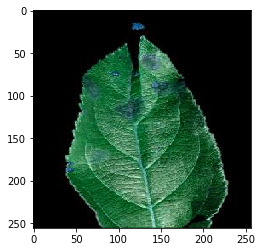

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [80]:
IMG_SIZE = 256
# img_array = cv2.imread("/home/yaan_uchiha29//RiceDetectGithub/TestPicturesColor//Tomato___healthy/00bce074-967b-4d50-967a-31fdaa35e688___RS_HL 0223.JPG") 
img_array = cv2.imread("/home/mazumder_8100/crowdAi/test/Apple___Apple_scab/0db71c1d-93d7-4481-b0d0-b73f995131a9___FREC_Scab 2976_final_masked.jpg") 

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) #RESIZE MAGES
img_array = img_to_array(new_array)


plt.imshow(new_array)
plt.show()
img_array

In [81]:
np_image_test = np.array(img_array, dtype=np.float16) / 225.0
np_image_test.shape

(256, 256, 3)

In [82]:
#Expand dimension to predict the model in keras

np_image_test = np.expand_dims(np_image_test, axis=0)
np_image_test.shape

(1, 256, 256, 3)

In [83]:
a = model.predict(np_image_test)

np.around(a[0], decimals=2)

array([ 0.04, -0.02,  0.04,  0.04,  0.04,  0.  , -0.22, -0.19,  0.04,
       -0.03, -0.04,  0.04,  0.04, -0.03, -0.03, -0.03, -0.03,  0.02,
        0.04, -0.01,  0.02, -0.04, -0.05,  0.04, -0.02], dtype=float32)

In [84]:
CATEGORIES = label_binarizer.classes_
CATEGORIES

array(['Apple___Apple_scab', 'Apple___Black_rot',
       'Apple___Cedar_apple_rust', 'Apple___healthy',
       'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
       'Corn_(maize)___Common_rust_',
       'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy',
       'Grape___Black_rot', 'Grape___Esca_(Black_Measles)',
       'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
       'Potato___Early_blight', 'Potato___Late_blight',
       'Potato___healthy', 'Tomato___Bacterial_spot',
       'Tomato___Early_blight', 'Tomato___Late_blight',
       'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',
       'Tomato___Spider_mites Two-spotted_spider_mite',
       'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
       'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'], dtype='<U50')

In [85]:
a = model.predict_classes(np_image_test)
print('Image prediction - '+CATEGORIES[int(a)])

Image prediction - Grape___Black_rot
